#Dataset can be downloaded from: [Sign Language Dataset(Kaggle)](https://www.kaggle.com/datamunge/sign-language-mnist?select=american_sign_language.PNG)

In [29]:
from os import getcwd
import csv
import numpy as np
import tensorflow as tf

In [30]:
#Sneak peak into the current form of data 
import pandas as pd
train_data = pd.read_csv("/content/drive/My Drive/American_Sign_Language/train.csv")
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


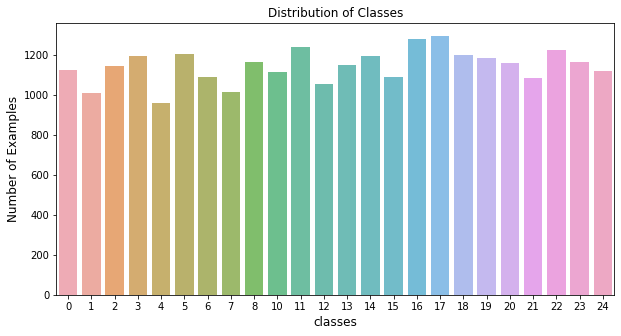

In [31]:
#Class distribution of data for 25 classes representing hand gestures for American Sign Language letters
import matplotlib.pyplot as plt
import seaborn as sns

labels_count  = train_data['label'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(labels_count.index, labels_count.values, alpha=0.8)
plt.title('Distribution of Classes')
plt.ylabel('Number of Examples', fontsize=12)
plt.xlabel('classes', fontsize=12)
plt.show()

In [32]:
''' This function will read the file passed to it. The data is present in .csv format
    in such a way that each successive line contains 785 comma separated values between 0 and 255.
    The first column is of target label and the rest 784 columns represent pixel values for the specific images.
'''

def get_data(filename):
  with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = [] 
        temp_labels = []
        for row in csv_reader:
            if first_line:
                first_line = False
            else:
                temp_labels.append(row[0]) #row[0] has the label
                image_data = row[1:785] #row[1:785] has the 784 pixel values.

                #The np.array_split will turn the 784 pixels into 28 x 28.
                image_data_as_array = np.array_split(image_data, 28) 
                temp_images.append(image_data_as_array)

        '''We are reading in strings, but we need the values to be floats.
        Hence, we will use np.array().astype for a conversion'''
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')

  #Returns 2 np.array, one with all the images and other with all the labels
  return images, labels

In [33]:
train_path = f"{getcwd()}/../content/drive/My Drive/American_Sign_Language/train.csv"
test_path = f"{getcwd()}/../content/drive/My Drive/American_Sign_Language/test.csv"


In [34]:
X_train, Y_train = get_data(train_path)
X_test, Y_test = get_data(test_path)

In [35]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


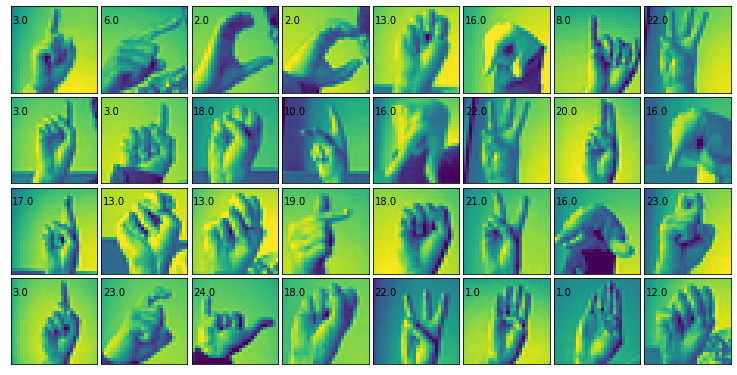

In [36]:
#Visualizing first few images

fig = plt.figure(figsize=(10, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(32):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap='viridis', interpolation='nearest')
    # label the image with the target value
    ax.text(0, 5, str(Y_train[i]))


In [37]:
#Adding another dimension
X_train = np.expand_dims(X_train, axis=3) 
X_test = np.expand_dims(X_test, axis=3)

print(X_train.shape)
print(X_test.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


In [38]:
# Create an ImageDataGenerator and perform Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
  
validation_datagen = ImageDataGenerator(
    rescale=1. / 255)


In [39]:
#Creating Callback function to stop the model training when a specific accuracy or loss is achieved!

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy, so training is stopped!")
      self.model.stop_training = True

callbacks = myCallback()

In [40]:
#Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(25, activation=tf.nn.softmax)])

#Compile the Model. 
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Display a summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               819712    
_________________________________________________________________
dense_5 (Dense)              (None, 25)               

In [41]:
# Train the Model
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size=32),
                              steps_per_epoch=len(X_train) / 32,
                              epochs=50,
                              validation_data=validation_datagen.flow(X_test, Y_test, batch_size=32),
                              validation_steps=len(X_test) / 32,
                              callbacks=[callbacks])

Epoch 1/50
858/857 [==============================] - 14s 17ms/step - loss: 2.5727 - accuracy: 0.2115 - val_loss: 1.5357 - val_accuracy: 0.4969
Epoch 2/50
858/857 [==============================] - 14s 17ms/step - loss: 1.6253 - accuracy: 0.4728 - val_loss: 1.0439 - val_accuracy: 0.6392
Epoch 3/50
858/857 [==============================] - 14s 17ms/step - loss: 1.2040 - accuracy: 0.6063 - val_loss: 0.6654 - val_accuracy: 0.7724
Epoch 4/50
858/857 [==============================] - 14s 17ms/step - loss: 0.9503 - accuracy: 0.6838 - val_loss: 0.5014 - val_accuracy: 0.8193
Epoch 5/50
858/857 [==============================] - 14s 17ms/step - loss: 0.7840 - accuracy: 0.7379 - val_loss: 0.4365 - val_accuracy: 0.8480
Epoch 6/50
858/857 [==============================] - 14s 16ms/step - loss: 0.6904 - accuracy: 0.7702 - val_loss: 0.3080 - val_accuracy: 0.8972
Epoch 7/50
858/857 [==============================] - 14s 16ms/step - loss: 0.6018 - accuracy: 0.8000 - val_loss: 0.2949 - val_accuracy:

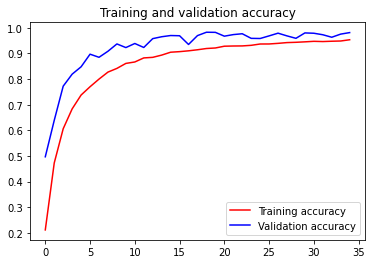

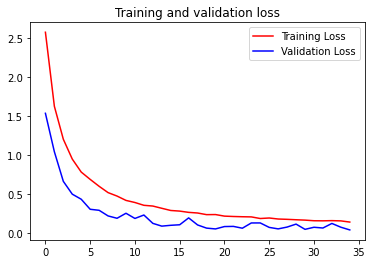

In [42]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
#Evaluation of the model on Testing images

test_loss, test_acc = model.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

225/225 [==============================] - 1s 3ms/step - loss: 44.8399 - accuracy: 0.9257
Test Loss:  44.83987808227539
Test Accuracy:  0.9256832003593445
